In [1]:
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
notebook_rc = dict(mpl.rcParams)
# mpl.rcParams.update(notebook_rc)

from numpy.lib.stride_tricks import as_strided

from mypy.theutility import *
from mypy.quickvis import canvas
#canvas(12.3, 12.3)

In [2]:
from pathlib import Path
data_dir = Path('./cinc2011/')

In [3]:
import requests
import tarfile
def get_tar_data(url):
    file_loc = data_dir / url.split('/')[-1]
    r = requests.get(url)
    with file_loc.open('wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    tarfile.open(str(file_loc)).extractall(str(data_dir))
    return
#get_tar_data('https://physionet.org/physiobank/database/challenge/2011/set-a.tar.gz')
#get_tar_data('https://physionet.org/physiobank/database/challenge/2011/set-b.tar.gz')

In [4]:
train_dir = data_dir / 'set-a'
idents_list = []
for suffix in '', '-acceptable', '-unacceptable':
    name = 'RECORDS' + suffix
    with (train_dir / name).open('r') as f:
        idents_list.append([int(x) for x in f.readlines()])
[ident_all, ident_good, ident_bad] = [sp.asarray(idents) for idents in idents_list]
orig_tables = {}
for i in ident_all:
    orig_tables[i] = pd.read_csv(train_dir / '{}.txt'.format(i), header=None, usecols=range(1, 13))
    orig_tables[i].columns = 'I II III aVR aVL aVF V1 V2 V3 V4 V5 V6'.split()

In [5]:
def _normalize(table):
    table_min, table_max = table.min(), table.max()
    table_range = table_max - table_min
    return (table - table_min) / table_range # (sp.where(table_range == 0, 1, table_range))
norm_tables = dictmap(_normalize, orig_tables)
def _downsample(table):
    s = (table.index.to_series() / 5).astype(table.index.dtype)
    return table.groupby(s).mean()
downsamp_tables = dictmap(_downsample, norm_tables)

In [9]:
import plotly.tools as tls
import plotly.plotly as py
import cufflinks as cf
thetables = downsamp_tables
table = thetables[ident_good[283]]
ax = (table + list(range(11, -1, -1))).plot()
plt.xlabel('time sample')
plt.yticks([], [])
plt.title('ECG signals')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig = plt.gcf()

ImportError: No module named 'cufflinks'

In [6]:
def _variation(table):
    return table.diff().abs().sum()
variation_tables = dictmap(_variation, norm_tables)
variations_good = sp.stack(variation_tables[i].as_matrix() for i in ident_good)
variations_bad = sp.stack(variation_tables[i].as_matrix() for i in ident_bad)

<IPython.core.display.Javascript object>


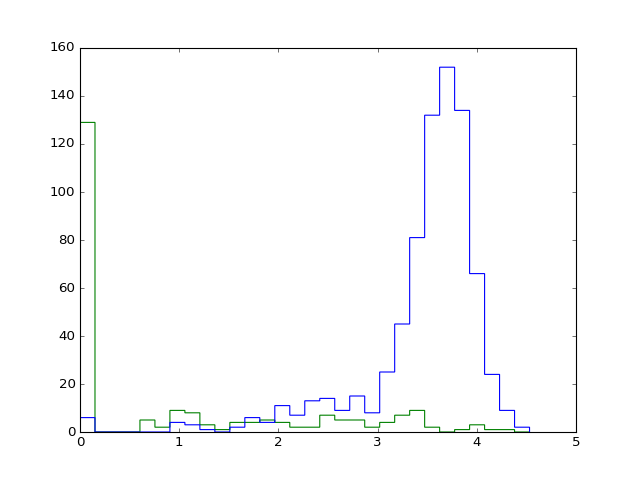

IDs of good records with a flat signal (0 variation) in one lead:  [1968453 2080991 2151032 2536401 2537839 2883516]
The number of good records with no flat signals:  767
The number of bad records with no flat signals:  96


In [7]:
_v = variations_good, variations_bad
plt.hist([sp.log(v.min(axis=1) + 1) for v in _v], bins=30, histtype='step')
ident_good_missing = ident_good[sp.where((variations_good == 0).sum(axis=1) == 1)[0]]
print('IDs of good records with a flat signal (0 variation) in one lead: ', ident_good_missing)
ident_good_complete = ident_good[sp.where((variations_good == 0).sum(axis=1) == 0)[0]]
print('The number of good records with no flat signals: ', len(ident_good_complete))
ident_bad_complete = ident_bad[sp.where((variations_bad == 0).sum(axis=1) == 0)[0]]
print('The number of bad records with no flat signals: ', len(ident_bad_complete))

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
ident_all_complete = sp.concatenate([ident_good_complete, ident_bad_complete])
_label = sp.in1d(ident_all_complete, ident_bad_complete)
_train, _validation = skf.split(ident_all_complete, _label).__next__()
ident_train = ident_all_complete[_train]
label_train = _label[_train]
ident_validation = ident_all_complete[_validation]
label_validation = _label[_validation]

In [48]:
def rolling_window(x, window, axis):
    if axis < 0:
        axis += len(x.shape)
    shape = x.shape[:axis] + (x.shape[axis] - window + 1, window) + x.shape[axis + 1:]
    strides = x.strides[:axis] + (x.strides[axis],) + x.strides[axis:]
    return as_strided(x, shape=shape, strides=strides)
thetables = downsamp_tables
n_samples = 25#431
sample_length = 160
def _create_samples(i):
    matrix = thetables[i].as_matrix()
    samples_idx = sp.random.permutation(matrix.shape[0] - sample_length + 1)[:n_samples]
    windows = rolling_window(matrix, sample_length, 0)
    return windows[samples_idx]
X = sp.concatenate([_create_samples(i) for i in ident_train])
X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
l = sp.concatenate([lbl * sp.ones(n_samples) for lbl in label_train])

In [62]:
from scipy.spatial.distance import pdist, squareform
import scipy.linalg as linalg
from mpl_toolkits.mplot3d import Axes3D
from time import time
t0 = time()

auto = lambda x: sp.outer(x, x)
alpha = 0
E = squareform(pdist(X, 'sqeuclidean'))
# select 7th nearest neighbour for self tuning
sigma = sp.sqrt(sp.sort(E, axis=0)[75])
# run kernel on self tuned afinity
W = sp.exp(-E * auto(1 / sigma))
d = W.sum(axis=0)
# alpha normalization
W = W * auto(d ** -alpha)

# make helper vars
d = W.sum(axis=0)
d_sqrt = sp.sqrt(d)
d_sqrt_inv = 1 / d_sqrt

# find eigenvectors of diffusion transition matrix
mu, O = sp.linalg.eigh(W * auto(d_sqrt_inv), eigvals=(len(d) - 4, len(d) - 1))
# eigh puts eigenvalues in ascending order, but we want descending order
flip = list(reversed(range(mu.shape[0])))
# note: O@diag(mu)@O = (O@I[flip])@(I[flip]@diag(mu)@I[flip])@(I[flip@O.T)
mu = mu[flip]
O = O.T[flip].T

# define the final matrices
U = d_sqrt_inv[:, sp.newaxis] * O
V = d_sqrt[:, sp.newaxis] * O
DM = memoized(lambda t: U * mu ** t)

t1 = time()
t1 - t0

203.25213289260864

In [63]:
dm = DM(0)

import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Scatter3d(
    x=dm[:, 1],
    y=dm[:, 2],
    z=dm[:, 3],
    mode='markers',
    marker=dict(
        size='1',
        color=label_train * 1,
        showscale=True,
        colorscale='Jet',
        opacity=1
    )
)
data = [trace]
py.iplot(data)


<IPython.core.display.Javascript object>


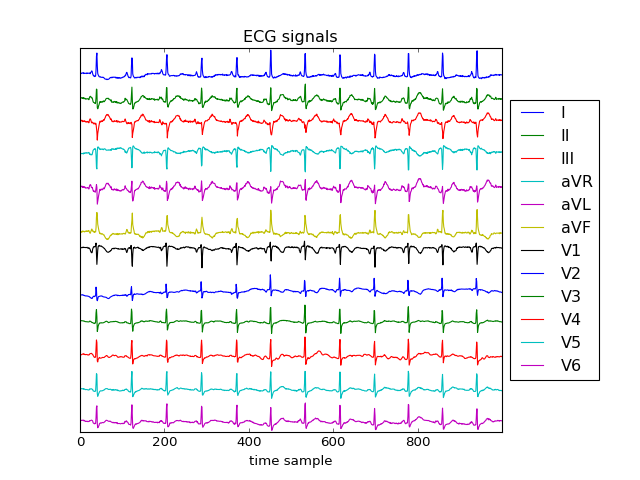

In [13]:
thetables = downsamp_tables
table = thetables[ident_good[283]]
ax = (table + list(range(11, -1, -1))).plot()
plt.xlabel('time sample')
plt.yticks([], [])
plt.title('ECG signals')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.85, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
import os
os.system("taskset -p {}".format(os.getpid()))

0